In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm
from tqdm import tqdm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 30
mtype = 'assetcov_gics'

with open("../../mlr_fitting_private/data_finance/crsp_gics_5k_hpart.pkl", "rb") as f:
       gics_hpart = pickle.load(f)

with open('../../mlr_fitting_private/data_finance/crsp_gics_5k_C.npy', 'rb') as f:
       C = np.load(f)

m = n = gics_hpart['rows']['pi'].size
part_sizes = []
for level in range(len(gics_hpart['rows']['lk'])):
    part_sizes += [gics_hpart['rows']['lk'][level].size-1]
    print(f"{level=}, {gics_hpart['rows']['lk'][level].size-1}")

Z = mf.demean_clip(C)
A = Z @ Z.T / (Z.shape[1]-1)

level=0, 1
level=1, 11
level=2, 24
level=3, 69
level=4, 157
level=5, 5000


In [4]:
np.sort(np.abs(np.linalg.eigvalsh(A)))[::-1][:10]

array([1.80995933, 0.24351866, 0.17073495, 0.11152992, 0.08905731,
       0.080994  , 0.06320885, 0.05705067, 0.05527067, 0.05144684])

In [5]:
np.histogram(np.sort(np.abs(np.linalg.eigvalsh(A)))[::-1][:100], bins=8)

(array([99,  0,  0,  0,  0,  0,  0,  1]),
 array([0.02193369, 0.24543689, 0.4689401 , 0.6924433 , 0.91594651,
        1.13944971, 1.36295292, 1.58645612, 1.80995933]))

In [6]:
# U, Vt, sigmas = mf.frob_low_rank(A)
# frob_losses = np.zeros(m)
# normalization = np.linalg.norm(A, ord='fro')
# sigmas2 = (sigmas**2)[::-1]
# frob_losses = np.concatenate([(np.cumsum(sigmas2)**0.5)[::-1][1:] / normalization, np.array([0])])
# mf.plot_frob_error_rank(frob_losses)

In [7]:
C.shape, A.shape, A.min(), A.max(), A.mean(), A.std()

((5000, 300),
 (5000, 5000),
 -0.001839477534559251,
 0.014836883129622934,
 0.0002737358427138843,
 0.00025728376347159727)

In [8]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [9]:
# GICS hierarchy
num_levels = len(gics_hpart['rows']['lk'])

In [10]:
# permute to put clusters on diagonal
Y = Z[gics_hpart["rows"]["pi"], :].T
N = Y.shape[0]

In [11]:
row_selectors, si_groups, F_hpart = mfm.row_col_selections(gics_hpart)

num_levels=6, num_sparsities=157
(157, 5) [  0  10  23  68 156]


# Frobenius norm

In [12]:
obj_frobs = {}

In [13]:
hat_A = mf.MLRMatrix()
hat_A.hpart = gics_hpart
ranks = np.array([rank-1, 0, 0, 0, 0, 1])
losses = hat_A.factor_fit(A, ranks, hat_A.hpart, eps_ff=1e-3, PSD=True, freq=1, \
                                printing=True, max_iters_ff=50, symm=True)


F_frob, D_frob = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])
Sigma_frob = mfm.perm_hat_Sigma(F_frob, D_frob, F_hpart, ranks)
lu, piv = scipy.linalg.lu_factor(Sigma_frob)
obj_frob = mfm.loglikelihood_value(Sigma_frob, lu, piv, Y)
print(f"{obj_frob = }")
obj_frobs[str(ranks)] = obj_frob


/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:408: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


itr=0, 0.1541325347909012, [29  0  0  0  0  1]
itr=1, 0.1541325347909012, [29  0  0  0  0  1]
itr=1, 0.15379449543341234, [29  0  0  0  0  1], time_v_epoch=11.023930072784424, time_loss=0.7604353427886963
itr=2, 0.15379249118337152, [29  0  0  0  0  1], time_v_epoch=11.130659818649292, time_loss=0.743483304977417
obj_frob = 11808.872096245648


In [14]:
mf.rel_diff(hat_A.matrix(), den=A)

0.15379235173974629

In [15]:
np.linalg.slogdet(hat_A.matrix())

(1.0, -37702.343185018195)

In [16]:
# ranks = mf.uniform_capped_ranks(rank, gics_hpart) 
ranks = np.array([14, 6, 4, 3, 2, 1])
print(ranks.sum())
hat_A = mf.MLRMatrix()
hat_A.hpart = gics_hpart
losses = hat_A.factor_fit(A, ranks, hat_A.hpart, eps_ff=1e-3, PSD=True, freq=1, \
                                printing=True, max_iters_ff=50, symm=True)

F_frob, D_frob = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])
Sigma_frob = mfm.perm_hat_Sigma(F_frob, D_frob, F_hpart, ranks)
lu, piv = scipy.linalg.lu_factor(Sigma_frob)
obj_frob = mfm.loglikelihood_value(Sigma_frob, lu, piv, Y)
print(f"{obj_frob = }")
obj_frobs[str(ranks)] = obj_frob

30
itr=0, 0.16617119653534937, [14  6  4  3  2  1]
itr=1, 0.16617119653534937, [14  6  4  3  2  1]
itr=1, 0.16493897439347802, [14  6  4  3  2  1], time_v_epoch=11.41844892501831, time_loss=0.7479839324951172
itr=2, 0.16482424552301322, [14  6  4  3  2  1], time_v_epoch=11.391036748886108, time_loss=0.7561931610107422
obj_frob = 11955.956851218816


In [17]:
mf.rel_diff(hat_A.matrix(), den=A)

0.16479092911663543

In [18]:
np.linalg.slogdet(hat_A.matrix())

(1.0, -38056.193412982)

In [19]:
# LR             0.16178478761767232
# LR+D           0.1537922868665804

# MLE

# MLR initialization

In [20]:
# loglikelihoods = [-np.inf]
# F0, D0 = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])

# for t in range(80):
#     Sigma0 = perm_hat_Sigma(F0, D0, F_hpart, ranks)
#     lu, piv = scipy.linalg.lu_factor(Sigma0)
#     obj = loglikelihood_value(Sigma0, lu, piv, Y)
#     loglikelihoods += [obj]
#     print(f"{t=}, {obj=}")
#     F1 = EM_get_F(F0, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
#     D1 = EM_get_D(F0, F1, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
#     F0, D0 = F1, D1
#     assert D1.min() >= -1e-8 and loglikelihoods[-2] - 1e-8 <= loglikelihoods[-1]

# Random initialization

In [21]:
loglikelihoods = [-np.inf]
ranks = np.array([14, 6, 4, 3, 2, 1])

In [22]:
# F0, D0 = np.random.randn(n, rank-1), np.square(np.random.rand(n)) + 1

# for t in range(100):
#     Sigma0 = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
#     lu, piv = scipy.linalg.lu_factor(Sigma0)
#     obj = mfm.loglikelihood_value(Sigma0, lu, piv, Y)
#     loglikelihoods += [obj]
#     if t % 50 == 0:
#         print(f"{t=}, {obj=}")
#     F1 = mfm.EM_get_F(F0, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
#     D1 = mfm.EM_get_D(F0, F1, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
#     F0, D0 = F1, D1
#     assert D1.min() >= -1e-8 and loglikelihoods[-2] - 1e-8 <= loglikelihoods[-1]

In [23]:
loglikelihoods, F0, D0 = mfm.em_algorithm(n, Y, part_sizes, F_hpart, row_selectors, si_groups, ranks, max_iter=100, 
                eps=1e-8, printing=True, F0=np.random.randn(n, rank-1), D0=np.square(np.random.rand(n)) + 1)

t=0, obj=-6485.641221344158
t=50, obj=12107.44814607437


In [24]:
ll_hier = np.copy(np.array(loglikelihoods))

In [25]:
(12111.61302037138-11947.013581639769)

164.59943873161137

In [26]:
Sigma0 = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
mf.rel_diff(Sigma0, den=A[hat_A.pi_rows, :][:, hat_A.pi_cols]) #mf.rel_diff(Sigma0[hat_A.pi_inv_rows, :][:, hat_A.pi_inv_cols], den=A)

11.40950952328808

In [27]:
np.linalg.slogdet(Sigma0)

(1.0, -38411.086431116964)

In [28]:
loglikelihoods = [-np.inf]
ranks = np.array([rank-1, 0, 0, 0, 0, 1])

In [29]:
loglikelihoods, F0, D0 = mfm.em_algorithm(n, Y, part_sizes, F_hpart, row_selectors, si_groups, ranks, max_iter=100, 
                eps=1e-8, printing=True, F0=np.random.randn(n, rank-1), D0=np.square(np.random.rand(n)) + 1)

t=0, obj=-5380.380367585958
t=50, obj=11904.42823184209


In [30]:
# max_iter = 100
# F0, D0 = np.random.randn(n, rank-1), np.square(np.random.rand(n)) + 1
# for t in range(max_iter):
#     Sigma0 = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
#     lu, piv = scipy.linalg.lu_factor(Sigma0)
#     obj = mfm.loglikelihood_value(Sigma0, lu, piv, Y)
#     loglikelihoods += [obj]
#     if t % 50 == 0:
#         print(f"{t=}, {obj=}")
#     F1 = mfm.EM_get_F(F0, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
#     D1 = mfm.EM_get_D(F0, F1, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
#     F0, D0 = F1, D1
#     assert D1.min() >= -1e-8 and loglikelihoods[-2] - 1e-8 <= loglikelihoods[-1]

In [31]:
11905.103228657465 - 11808.569944996312

96.53328366115238

In [32]:
Sigma0 = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
mf.rel_diff(Sigma0, den=A[hat_A.pi_rows, :][:, hat_A.pi_cols]) #mf.rel_diff(Sigma0[hat_A.pi_inv_rows, :][:, hat_A.pi_inv_cols], den=A)

31.977597050955012

In [33]:
np.linalg.slogdet(Sigma0)

(1.0, -37995.43075939087)

In [34]:
ll_factor = np.copy(np.array(loglikelihoods))

In [35]:
11905-11809, 12112-11955

(96, 157)

ranks=array([29,  0,  0,  0,  0,  1]), difference=95.01, %increase=0.80
ranks=array([14,  6,  4,  3,  2,  1]), difference=147.96, %increase=1.24


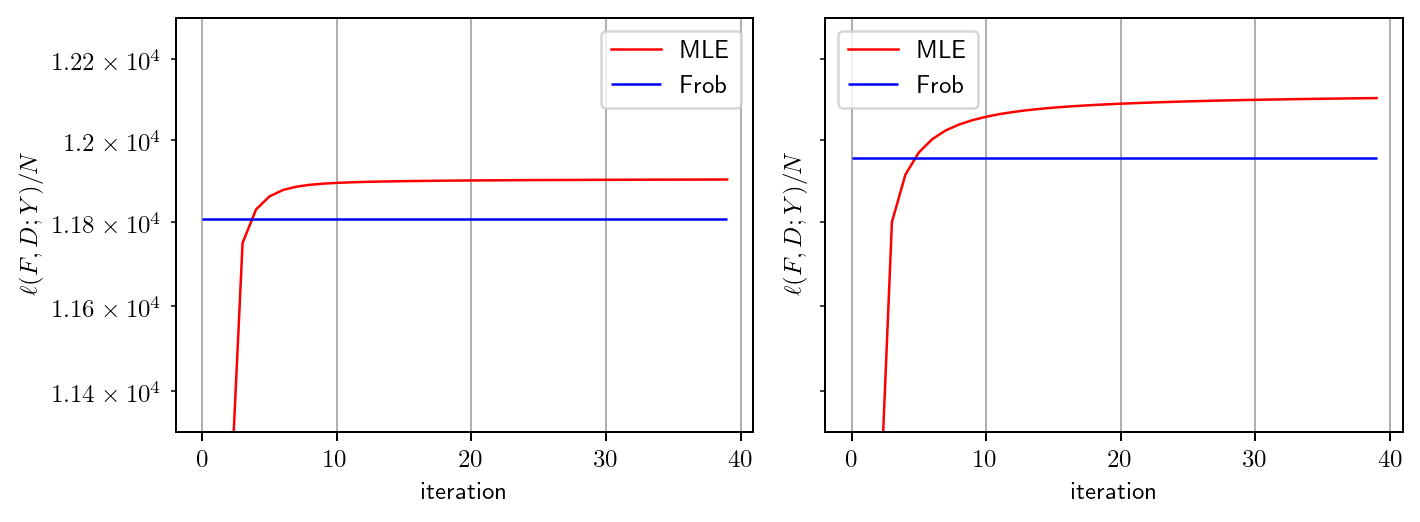

In [36]:
rs = [np.array([rank-1, 0, 0, 0, 0, 1]), np.array([14, 6, 4, 3, 2, 1])]
ll_all = [ll_factor, ll_hier]
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=180, sharey=True)
for i in range(2):
    ranks = rs[i]
    ll = ll_all[i][:40]
    print(f"{ranks=}, difference={(ll[-1]-obj_frobs[str(ranks)]):.2f}, %increase={(ll[-1]-obj_frobs[str(ranks)])/obj_frobs[str(ranks)]*100:.2f}")
    axs[i].plot(np.maximum(1, ll), color='r', lw=1, label=r"$\text{MLE}$")
    axs[i].set_xlabel('iteration')
    axs[i].hlines(obj_frobs[str(ranks)], 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$")
    axs[i].set_ylabel(r'$\ell(F, D; Y)/N$')
    axs[i].set_yscale('log')
    axs[i].set_ylim([ll.max()-800, ll.max() + 200])
    axs[i].grid(True)
    axs[i].legend()
    # axs[i].set_title(f"ranks$={list(ranks)}$")
# plt.show()
plt.tight_layout()
# fig.suptitle("Observed data log-likelihood", fontsize=16, y=1.05)
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')

In [37]:
with open(f"outputs/em_{mtype}.pickle", 'wb') as handle:
    lls = {"factor":ll_factor, "hier":ll_hier, "frob":obj_frobs}
    pickle.dump(lls, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
with open("em_gics.pickle", 'rb') as handle:
    mlls = pickle.load(handle)

In [39]:
mlls.keys()

dict_keys(['hier', 'frob'])

In [40]:
# fig, ax = plt.subplots(figsize=(8, 16), dpi=120)
# cax = ax.matshow(F1.T[:, 400:800], cmap='hot')
# fig.colorbar(cax)
# plt.show()

In [41]:
import numpy as np
np.sqrt(5000 / (2*300))

2.886751345948129

In [42]:
np.log(2*np.pi) * 5000/2 + 5000 / 2

7094.692666023363